In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
individual_details = pd.read_csv('New_Data/IndividualDetails.csv')

In [4]:
individual_details.head()

,id,government_id,diagnosed_date,age,gender,detected_city,detected_district,detected_state,nationality,current_status,status_change_date,notes
0,0,KL-TS-P1,30/01/2020,20,F,Thrissur,Thrissur,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
1,1,KL-AL-P1,02/02/2020,NaN,NaN,Alappuzha,Alappuzha,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
2,2,KL-KS-P1,03/02/2020,NaN,NaN,Kasaragod,Kasaragod,Kerala,India,Recovered,14/02/2020,Travelled from Wuhan
3,3,DL-P1,02/03/2020,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,India,Recovered,15/03/2020,"Travelled from Austria, Italy"
4,4,TS-P1,02/03/2020,24,M,Hyderabad,Hyderabad,Telangana,India,Recovered,02/03/2020,"Travelled from Dubai to Bangalore on 20th Feb,..."


#### The aim of this analysis is to understand various statistics related to the age group of the infected by Covid 19 in India.

In [5]:
age_cleaned = individual_details[["age", "detected_state"]]
age_cleaned = age_cleaned[pd.to_numeric(age_cleaned["age"], errors='coerce').notnull()]
age_cleaned = age_cleaned.astype({'age': 'int'})

Percentage of victims with age greater than 30. In China where this virus originated, this is 87 %. This might be attributed to younger population in India.

In [8]:
sum(age_cleaned["age"] > 30) / age_cleaned.count()

age               0.697173
detected_state    0.697173
dtype: float64

Age greater than 20

In [9]:
sum(age_cleaned["age"] > 20) / age_cleaned.count()

age               0.892113
detected_state    0.892113
dtype: float64

This can either be attributed to young population in India or the mutations in virus that are making it more resiliant allowing it to infect younger people.

Virus adapting to local conditions will have a few indicators in terms of decrease in average age with time and and places with high spread (Both these factors indicate more communal spread). This analysis would give more accurate results if community spread data is available. In case of India, this hasen't been properly documented after the forst 500 - 100 cases. So we resort to these methods to get an estimate.

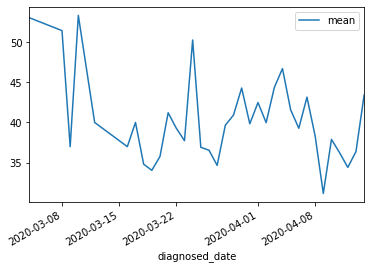

In [19]:
age_cleaned = individual_details[["age", "diagnosed_date"]]
age_cleaned = age_cleaned[pd.to_numeric(age_cleaned["age"], errors='coerce').notnull()]
age_cleaned = age_cleaned.astype({'age': 'int'})

age_cleaned = age_cleaned.groupby(["diagnosed_date"]).agg(["mean", "count"])["age"]
age_cleaned.index = pd.to_datetime(age_cleaned.index,dayfirst=True,format="%d/%m/%Y")
age_cleaned = age_cleaned.sort_index()
age_cleaned[age_cleaned["count"] >= 5].plot(y = "mean")

From the above plot, we can see a weak decrease in average age with time. But this is not conclusive. The sudden surges in the age can be explained by formation of new clusters.

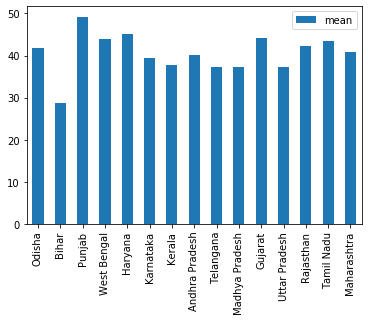

In [31]:
age_cleaned = individual_details[["age", "detected_state"]]
age_cleaned = age_cleaned[pd.to_numeric(age_cleaned["age"], errors='coerce').notnull()]
age_cleaned = age_cleaned.astype({'age': 'int'})
age_cleaned = age_cleaned.groupby(["detected_state"]).agg(["mean", "count"])["age"]
counts = individual_details[["detected_state", "id"]].groupby(["detected_state"]).agg(["count"])["id"]
counts.columns = ["all_counts"]
state_age = pd.concat([counts, age_cleaned], axis = 1,sort = True).sort_values(by = ["all_counts"])
ax = state_age[state_age["count"] > 20].plot(kind = "bar", y = "mean")

Above plot shows the distribution of average age in various geographical locations. Since age is nor properly documented in data provided by a few states, only the states for which proper data is available are considered.

From the plot, it can be seen that in most of the cases, the average age is around 45. There are two factors that can influence the average age of Covid victims in a state. First one is the average age for population of the state itself and the other one being high communal spread leading to lower age groups being affected. The plot correlates with the average population age of the states( Tamilnadu, Uttarpradesh have higher average while Maharastra has lower average for the average age of population in respective states.

##### Conclusions
- Even though Covid is known to affect people of older age group, in a community with an younger population, it can be seen that younger people are getting affected too. Whether a younger population means less rate of spread is a point of discussion*.
- There is no conclusive evidence to prove that the virus is growing resiliant to attack more young people with more communal spread. BUt the evidence weakly points to that happening. Another factor for this might be virus becoming more resiliant to local conditions rather than affecting younger people.
- More conclusions can be drawn combining this with further analysis on other factors.

*Although stats show that the rate of spread is less in India compared to other contries, various other probable reasons like exposure to Hydro Chloroquione(malarial cases in tropical countries), vaccinations for TB etc have been cited for this. So a younger community may not be the only explanation.